## Index
---

- <a href='#1'>1. Loading of Libraries and Data</a>

- <a href='#2'>2. EDA</a>

- <a href='#3'>3. Generation of features per cell and cycle </a>

## <a id='1'>1. Loading of Libraries and Data</a>
---

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

import warnings
warnings.filterwarnings('ignore')

In [2]:
path_origin = '../01_data/Datos_baterias_csv'

Creation of **SoH** and **SoC** in the original data for later use.

In [3]:
elements  = os.listdir(path_origin)
for r in elements:
    
    path = path_origin + f'/{r}'
    dirs = sorted(os.listdir(path), key=lambda x: float(x[3:]))
    
    for i in dirs:
        path2 = path+'/'+i
        archives = [archive for archive in os.listdir(path2) if 'V' not in archive]
        cyc_discharge = pd.read_csv(path2 + f'/{archives[0]}')
        cyc_charge = pd.read_csv(path2 + f'/{archives[1]}')
        if i == 'cyc0': 
            initial_capacity = cyc_discharge.q.values[-1]

        SoH = (cyc_discharge.q.values[-1]/initial_capacity)*100
        cyc_discharge['SoH'], cyc_charge['SoH'] = SoH, SoH
        cyc_discharge['SoC'], cyc_charge['SoC'] = (cyc_discharge.q/cyc_discharge.q.values[-1])*100, (cyc_charge.q/cyc_charge.q.values[-1])*100

        cyc_discharge.to_csv(path_or_buf=path2+f'/{archives[0]}',index= False)
        cyc_charge.to_csv(path_or_buf=path2+f'/{archives[1]}',index= False)

## <a id='2'>2. EDA</a>
---

In [4]:
cyc0ch = pd.read_csv(path_origin+'/Cell1/cyc0/cyc0000_C1ch.csv')
cyc0dc = pd.read_csv(path_origin+'/Cell1/cyc0/cyc0000_C1dc.csv')
cyc8200ch = pd.read_csv(path_origin+'/Cell1/cyc8200/cyc8200_C1ch.csv')
cyc8200dc = pd.read_csv(path_origin+'/Cell1/cyc8200/cyc8200_C1dc.csv')

In [5]:
cyc0ch.head()

,t,v,q,T,SoH,SoC
0,735954.858966,2.719213,-0.000049,41.295536,100.0,-0.000007
1,735954.858977,2.856135,0.206339,41.000046,100.0,0.028495
2,735954.858989,2.877108,0.412724,40.962608,100.0,0.056997
3,735954.859000,2.892908,0.619110,40.987579,100.0,0.085498
4,735954.859012,2.906382,0.825497,41.049992,100.0,0.114000


Text(0.5, 1.0, 'Charge and discharge curves in cicle 0 vs cicle 8200')

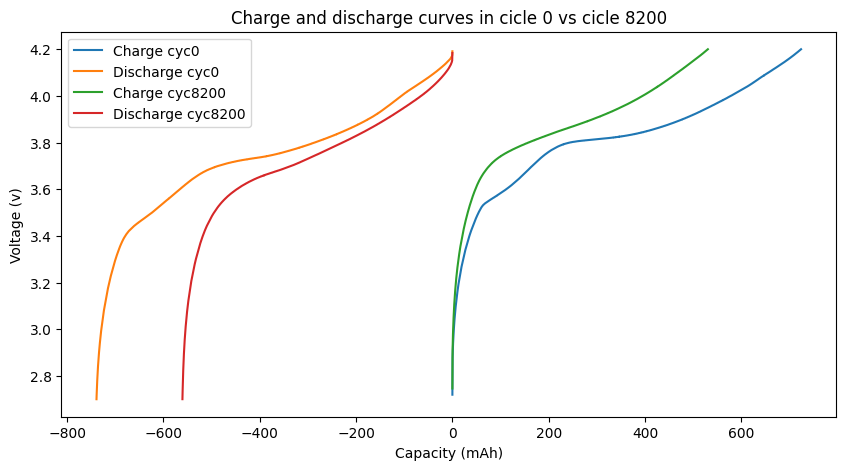

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(cyc0ch.q, cyc0ch.v, label='Charge cyc0')
plt.plot(cyc0dc.q, cyc0dc.v, label='Discharge cyc0')
plt.plot(cyc8200ch.q, cyc8200ch.v, label='Charge cyc8200')
plt.plot(cyc8200dc.q, cyc8200dc.v, label='Discharge cyc8200')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Voltage (v)')
plt.legend()
plt.title('Charge and discharge curves in cicle 0 vs cicle 8200')

In [7]:
print(f'The time of charge in cicle 0 is {cyc0ch.t.values[-1]-cyc0ch.t.values[0]} seconds.')
print(f'The time of discharge in cicle 0 is {cyc0dc.t.values[-1]-cyc0dc.t.values[0]} seconds.')
print(f'The time of charge in cicle 8200 is {cyc8200ch.t.values[-1]-cyc8200ch.t.values[0]} seconds.')
print(f'The time of discharge in cicle 8200 is {cyc8200dc.t.values[-1]-cyc8200dc.t.values[0]} seconds.')

The time of charge in cicle 0 is 0.04060957604087889 seconds.
The time of discharge in cicle 0 is 0.04173993202857673 seconds.
The time of charge in cicle 8200 is 0.029845685930922627 seconds.
The time of discharge in cicle 8200 is 0.03159782406874001 seconds.


Text(0.5, 1.0, 'Relation between time and SoC')

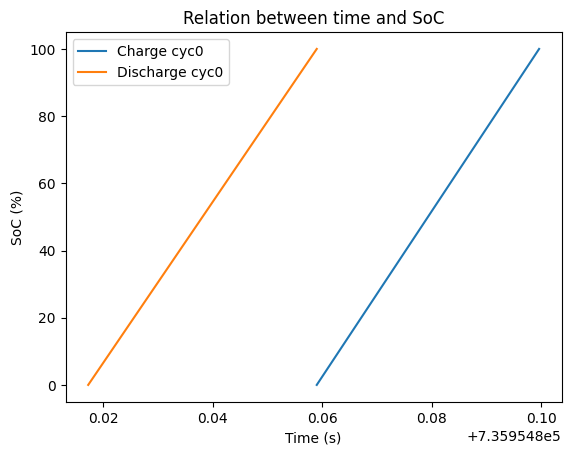

In [8]:
plt.plot(cyc0ch.t, cyc0ch.SoC, label='Charge cyc0')
plt.plot(cyc0dc.t, cyc0dc.SoC, label='Discharge cyc0')
plt.xlabel('Time (s)')
plt.ylabel('SoC (%)')
plt.legend()
plt.title('Relation between time and SoC')

# por qué son distintos los valores en carga y descarga en capacidad? HEMOS CREADO EL SOH CON DISCHARGE

In [9]:
print(cyc0ch.q.values[-1], cyc0dc.q.values[-1])

724.120891409319 -739.110921062178


## <a id='3'>3. Generation of features per cell and cycle</a>
---

In [11]:
df_full = pd.DataFrame(columns=['cell','cycle','type','t','v','q','T','SoH'])

for r in elements:
    
    path = path_origin + f'/{r}'
    dirs = sorted(os.listdir(path), key=lambda x: float(x[3:]))
    
    for i in dirs:
        df_partial = pd.DataFrame(columns=['cell','cycle','type','t','v','q','T','SoH'])
        path2 = path+'/'+i
        archives = [archive for archive in os.listdir(path2) if 'V' not in archive]
        cyc_discharge = pd.read_csv(path2 + f'/{archives[0]}')
        cyc_charge = pd.read_csv(path2 + f'/{archives[1]}')
        types, types_str = [cyc_discharge,cyc_charge], ['dc','ch']
        
        for j in range(len(types)):
            df_partial['t'], df_partial['v'], df_partial['q'], df_partial['T'], df_partial['SoH'] = types[j]['t'], types[j]['v'], types[j]['q'], types[j]['T'], types[j]['SoH']
            df_partial['cell'], df_partial['cycle'], df_partial['type'] = r[4:], i[3:], types_str[j]
            df_full = df_full.append(df_partial, ignore_index=True)

Extract **characteristics** per cell, cycle and type:

In [12]:
df_desc = pd.pivot_table(df_full, values=['t','v','q','T','SoH'], index=['cell','cycle','type'], aggfunc={'t':['max','min'], 'v':['max','min','mean','std', skew, kurtosis],
                                                               'q':['max','min','mean','std', skew, kurtosis],'T':['max','min','mean','std', skew, kurtosis],'SoH':'max'})

df_desc.columns = [i[0]+'_'+i[1] for i in df_desc.columns]
df_desc['t_total'] = df_desc['t_max'] - df_desc['t_min']
df_desc.drop(columns=['t_max','t_min'], inplace=True)

**Combine** charge and discharge features into one row per cell and cycle.

In [13]:
df_desc_final = pd.DataFrame(columns = ['cell','cycle'] + [col + '_ch' for col in list(df_desc.columns)] + [col + '_dc' for col in list(df_desc.columns)])
for ind in range(len(df_desc.index)):
    if ind % 2 == 0:
        values = list(df_desc.loc[df_desc.index[ind],:]) + list(df_desc.loc[df_desc.index[ind+1],:])
        df_desc_final.loc[ind//2,:] = [df_desc.index[ind][0],df_desc.index[ind][1]] + values

In [14]:
df_desc_final = df_desc_final.apply(pd.to_numeric, errors='coerce')
df_desc_final.sort_values(by=['cell','cycle'], inplace=True)
df_desc_final.set_index(['cell','cycle'], inplace=True)

In [15]:
eol = dict()
for bateria in df_desc_final.index.get_level_values(0).unique().tolist():
    df_part = df_desc_final.loc[bateria,:]
    for ciclo in range(len(df_part)):
        if df_part.iloc[ciclo, 0] < 80:
            eol[bateria] = ciclo*100
            break



df_desc_final['RUL'] = df_desc_final.index.get_level_values(0).astype(int).map(eol)
df_desc_final['RUL'] = df_desc_final['RUL'] - df_desc_final.index.get_level_values(1).astype(int)

In [16]:
df_desc_final.head()

SoH_max_ch  T_kurtosis_ch   T_max_ch  T_mean_ch   T_min_ch  \
cell cycle                                                               
1    0      100.000000      -1.083936  41.174809  40.407376  39.901646   
     100     98.676209      -1.188189  41.124866  40.314679  39.801758   
     200     98.029812      -1.184674  41.112400  40.315173  39.814266   
     300     97.641065      -1.179126  41.124866  40.309946  39.789291   
     400     96.977493      -1.168146  41.124866  40.302588  39.789291   

            T_skew_ch  T_std_ch  q_kurtosis_ch  q_max_ch   q_mean_ch  ...  \
cell cycle                                                            ...   
1    0       0.528187  0.344139      -1.200000       0.0 -359.585275  ...   
     100     0.494053  0.370530      -1.200106       0.0 -354.826094  ...   
     200     0.501045  0.362974      -1.200042       0.0 -352.430166  ...   
     300     0.524198  0.372747      -1.200020       0.0 -350.954383  ...   
     400     0.521274  0.371967      -1.200076       0.0 -348.658258  ...   

            q_skew_dc    q_std_dc  v_kurtosis_dc  v_max_dc  v_mean_dc  \
cell cycle                                                              
1    0      -0.000008  209.148607       1.668740  4.199977   3.819664   
     100    -0.000120  206.407459       1.661299  4.200017   3.821715   
     200    -0.000030  205.020342       1.691731  4.199897   3.822391   
     300     0.000029  204.241309       1.733821  4.199801   3.822893   
     400    -0.000063  202.847183       1.764507  4.199881   3.823835   

            v_min_dc  v_skew_dc  v_std_dc  t_total_dc   RUL  
cell cycle                                                   
1    0      2.719213  -0.969205  0.221073    0.040610  4600  
     100    2.719614  -0.961001  0.219879    0.040073  4500  
     200    2.719775  -0.968342  0.219837    0.039813  4400  
     300    2.720641  -0.982355  0.220404    0.039645  4300  
     400    2.720881  -0.987536  0.219984    0.039380  4200  

[5 rows x 41 columns]